In [4]:
########################################
# Packages
########################################
import warnings
import h5py as h5
import numpy as np
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt
import math

import statistics

from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic

import seaborn as sns

In [2]:
########################################
# Functions and values
########################################
h0=0.6751    # h0 value used for the SURFS DM-only simulation used to generate these outputs (Planck+2015)
Gyr2yr=1e9
ncpu=128    # Number of cores, only important if reading the files in parallel (see near the end of the code)
warnings.filterwarnings('ignore',message='invalid value encountered in divide')

In [3]:
def SHARK_parallel_read(shark_file,sv):
    shark_hdf5=h5.File(shark_file)
    
    gal_sv={}
    
    # Shark properties
    # Note the modification of galaxy/group IDs. This is because these IDs are only unique per subvolume, i.e.,
    # you can have up to 64 galaxies with with the same ID (one per each simulation subvolume).
    # If you want the true IDs it would be as simple as replacing these lines with something like
    # gal_sv['ID_galaxy']=shark_hdf5['galaxies']['id_galaxy'][()]
    gal_sv['ID_galaxy']=np.array([f'{sv}_{gid}' for gid in shark_hdf5['galaxies']['id_galaxy'][()]])
    gal_sv['ID_subhalo']=np.array([f'{sv}_{hid}' for hid in shark_hdf5['galaxies']['id_subhalo'][()]])
    gal_sv['ID_subhalo_tree']=np.array([f'{sv}_{hid}' for hid in shark_hdf5['galaxies']['id_subhalo_tree'][()]])
    gal_sv['ID_halo']=np.array([f'{sv}_{hid}' for hid in shark_hdf5['galaxies']['id_halo'][()]])
    gal_sv['sv']=(np.ones(len(shark_hdf5['galaxies']['id_galaxy'][()]))*sv).astype('int')
    gal_sv['type']=shark_hdf5['galaxies']['type'][()]
    # Halo masses
    gal_sv['Mhalo_host']=shark_hdf5['galaxies']['mvir_hosthalo'][()].astype('float64')/h0
    gal_sv['Mhalo']=shark_hdf5['galaxies']['mvir_subhalo'][()].astype('float64')/h0
    # Stellar masses
    gal_sv['Mstar_bulge']=shark_hdf5['galaxies']['mstars_bulge'][()].astype('float64')/h0
    gal_sv['Mstar_disc']=shark_hdf5['galaxies']['mstars_disk'][()].astype('float64')/h0
    gal_sv['Mstar_all']=gal_sv['Mstar_bulge']+gal_sv['Mstar_disc']
    gal_sv['Mstar_stripped']=shark_hdf5['galaxies']['mstars_tidally_stripped'][()].astype('float64')/h0
    # Gas masses
    gal_sv['Mhotgas']=shark_hdf5['galaxies']['mhot'][()].astype('float64')/h0
    gal_sv['Mcoldgas_bulge']=shark_hdf5['galaxies']['mgas_bulge'][()].astype('float64')/h0
    gal_sv['Mcoldgas_disc']=shark_hdf5['galaxies']['mgas_disk'][()].astype('float64')/h0
    gal_sv['Mcoldgas_all']=gal_sv['Mcoldgas_bulge']+gal_sv['Mcoldgas_disc']
    # Galaxy sizes
    gal_sv['Rgas_bulge']=1e3*shark_hdf5['galaxies']['rgas_bulge'][()].astype('float64')/h0
    gal_sv['Rgas_disc']=1e3*shark_hdf5['galaxies']['rgas_disk'][()].astype('float64')/h0
    gal_sv['Rgas_all']=(gal_sv['Mstar_bulge']*gal_sv['Rgas_bulge']+gal_sv['Mstar_disc']*gal_sv['Rgas_disc'])/gal_sv['Mstar_all']
    gal_sv['Rstar_bulge']=1e3*shark_hdf5['galaxies']['rstar_bulge'][()].astype('float64')/h0
    gal_sv['Rstar_disc']=1e3*shark_hdf5['galaxies']['rstar_disk'][()].astype('float64')/h0
    gal_sv['Rstar_all']=(gal_sv['Mstar_bulge']*gal_sv['Rstar_bulge']+gal_sv['Mstar_disc']*gal_sv['Rstar_disc'])/gal_sv['Mstar_all']
    # SFR
    gal_sv['SFR_bulge']=shark_hdf5['galaxies']['sfr_burst'][()].astype('float64')/(h0*Gyr2yr)
    gal_sv['SFR_disc']=shark_hdf5['galaxies']['sfr_disk'][()].astype('float64')/(h0*Gyr2yr)
    gal_sv['SFR_all']=gal_sv['SFR_bulge']+gal_sv['SFR_disc']
    # BH properties
    gal_sv['MBH']=shark_hdf5['galaxies']['m_bh'][()].astype('float64')/h0
    gal_sv['MBHacc_cold']=shark_hdf5['galaxies']['bh_accretion_rate_sb'][()].astype('float64')/(h0*Gyr2yr)
    gal_sv['MBHacc_hot']=shark_hdf5['galaxies']['bh_accretion_rate_hh'][()].astype('float64')/(h0*Gyr2yr)
    gal_sv['MBHacc_all']=gal_sv['MBHacc_cold']+gal_sv['MBHacc_hot']
    # Ejected gas
    gal_sv['Mgas_lost_SF']=shark_hdf5['galaxies']['mreheated'][()].astype('float64')/h0
    gal_sv['Mgas_lost_QSO']=shark_hdf5['galaxies']['mlost'][()].astype('float64')/h0
    gal_sv['BHspin']=shark_hdf5['galaxies']['bh_spin'][()]
    
    # pandas DataFrame
    gal_sv=pd.DataFrame(gal_sv)
    gal_sv=gal_sv.drop(gal_sv[gal_sv['Mstar_all']<1e8].index)    # Galaxies below this mass tend to reside in poorly-resolved haloes
    shark_hdf5.close()
    
    return(gal_sv)

In [4]:
########################################
# Reading data
########################################
sv_list=np.arange(64)
sharkfiles=[f'extracted_data_z=0/199/{sv}/galaxies.hdf5' for sv in sv_list] 

# To read in parallel
#pool=mp.Pool(processes=ncpu)
#shark_csv=[pool.apply_async(SHARK_parallel_read,(sf,sv,)) for sf,sv in zip(sharkfiles,sv_list)]
#shark_csv=[sc.get() for sc in shark_csv]
#pool.close()
# Otherwise use this
shark_csv=[SHARK_parallel_read(sf,sv) for sf,sv in zip(sharkfiles,sv_list)] 
shark_csv=pd.concat(shark_csv,ignore_index=True)

In [5]:
#print(shark_csv)

In [6]:
##Logging values rather than axes

#HaloM = shark_csv['Mhalo_host']
#logHaloM = HaloM.apply(np.log10)
#print(logHaloM)

##Linear regression

#slope, intercept = np.polyfit(shark_csv['Mhalo_host'], shark_csv['Mstar_all'], 1)
#regression_line = slope * shark_csv['Mhalo_host'] + intercept
#plt.plot(shark_csv['Mhalo_host'], regression_line, color='red', label=f"y = {slope:.2f}x + {intercept:.2f}")

#density plot (hexbin) pyplot.hexbin [DONE]
#"bin" the data 
# satellites

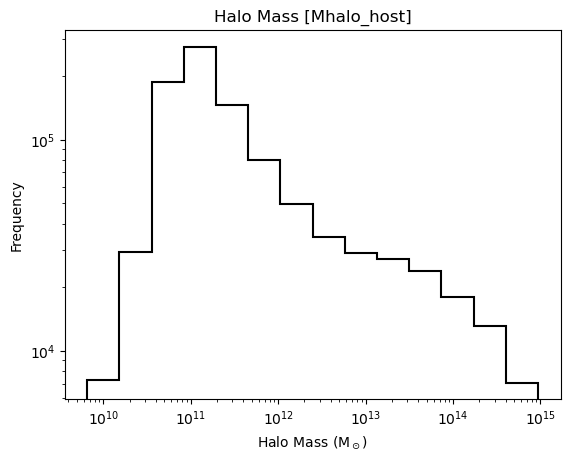

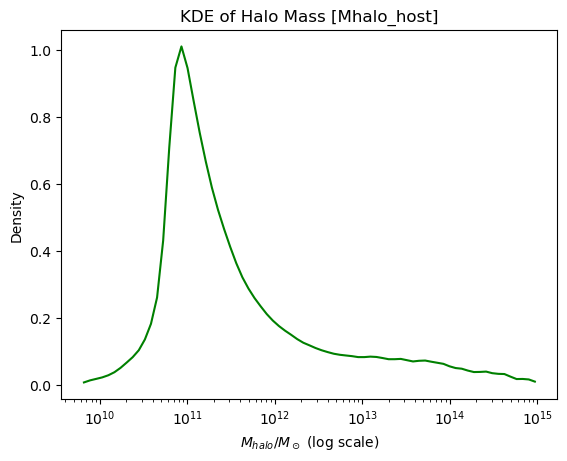

In [60]:
########################
# Halo Mass
########################
# Histogram
########################
HaloM = shark_csv['Mhalo_host']

# Logarithmically spaced histogram bins
bins1 = np.logspace(np.log10(HaloM.min()), np.log10(HaloM.max()), 15, base=10)

plt.hist(HaloM, bins=bins1, log=True, histtype='step',linewidth=1.5,color='black')
plt.xscale('log')
plt.xlabel(r'Halo Mass (M$_\odot$)')
plt.ylabel('Frequency')
plt.title('Halo Mass [Mhalo_host]')
plt.show()

########################
# KDE
########################
HaloM_filtered = HaloM[HaloM > 0]  # Eliminate non-positive values

# Log-transform then KDE
HaloM_log = np.log10(HaloM_filtered)
kde = gaussian_kde(HaloM_log)

# Create a grid of values in the log-transformed space
x_vals_log = np.linspace(min(HaloM_log), max(HaloM_log), 75)
kde_vals = kde(x_vals_log)

# Plot the KDE
plt.plot(10**x_vals_log, kde_vals, color='g')  # Use 10^log_vals to plot on original mass scale

# Set x-axis to be logarithmic
plt.xscale('log')

# Update labels and title
plt.xlabel(r'$M_{halo}/M_\odot$ (log scale)')
plt.ylabel("Density")
plt.title("KDE of Halo Mass [Mhalo_host]")
plt.show()

In [ ]:
########################################
# Stellar Mass (Histogram + KDE)
########################################
StellarM = shark_csv['Mstar_all']

fig, ax3 = plt.subplots()

# Plot the histogram on the first y-axis
bins2 = np.logspace(np.log10(StellarM.min()), np.log10(StellarM.max()), 15, base=10)
ax3.hist(StellarM, bins=bins2, log=True, histtype='step', linewidth=1.5, color='black')
ax3.set_xscale('log')
plt.xlabel(r'Stellar Mass (M$_\odot$)')
plt.ylabel('Frequency')
plt.title('Stellar Mass [Mstar_all]')

# Create a second y-axis sharing the same x-axis
ax4 = ax3.twinx()

# Log-transform the Stellar mass values
StellarM_filtered = StellarM[StellarM > 0]  # Eliminate non-positive values
StellarM_log = np.log10(StellarM_filtered)
kdeStellar = gaussian_kde(StellarM_log)

# Create a grid of values in the log-transformed space
x_vals_logStellar = np.linspace(min(StellarM_log), max(StellarM_log), 180)
kde_valsStellar = kdeStellar(x_vals_logStellar)

# Plot the KDE on the second y-axis
ax4.plot(10**x_vals_logStellar, kde_valsStellar, color='g')
ax4.set_yscale('linear')  # Ensure the y-axis for KDE is linear
ax4.set_ylim(0, 1)  # Set the density range between 0 and 1
ax4.set_ylabel('Density')
ax4.set_ylim(0, 1.1)

# Show the plot
plt.show()

In [2]:
fig, ax1 = plt.subplots()

# Plot the histogram on the first y-axis
bins1 = np.logspace(np.log10(HaloM.min()), np.log10(HaloM.max()), 15, base=10)
ax1.hist(HaloM, bins=bins1, log=True, histtype='step', linewidth=1.5, color='black')
ax1.set_xscale('log')
ax1.set_xlabel(r'Halo Mass (M$_\odot$)')
ax1.set_ylabel('Frequency')
ax1.set_title('Halo Mass and KDE [Mhalo_host]')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Log-transform the Halo mass values
HaloM_filtered = HaloM[HaloM > 0]  # Eliminate non-positive values
HaloM_log = np.log10(HaloM_filtered)
kde = gaussian_kde(HaloM_log)

# Create a grid of values in the log-transformed space
x_vals_log = np.linspace(min(HaloM_log), max(HaloM_log), 75)
kde_vals = kde(x_vals_log)

# Plot the KDE on the second y-axis
ax2.plot(10**x_vals_log, kde_vals, color='g')
ax2.set_yscale('linear')  # Ensure the y-axis for KDE is linear
ax2.set_ylim(0, 1)  # Set the density range between 0 and 1
ax2.set_ylabel('Density')


# Show the plot
plt.show()

NameError: name 'plt' is not defined

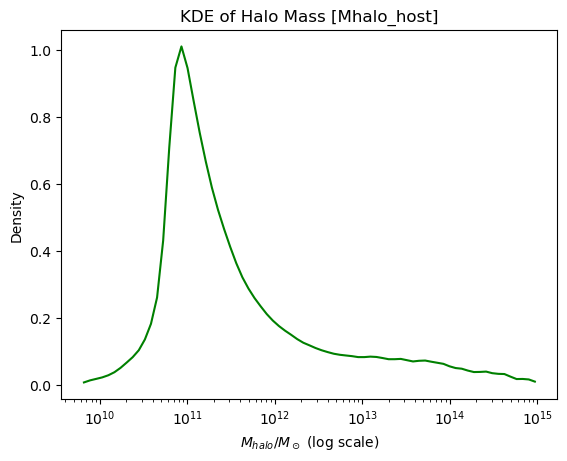

In [52]:
HaloM_filtered = HaloM[HaloM > 0]  # Failsafe to ensure no non-positive values

# Log-transform the Halo mass values
HaloM_log = np.log10(HaloM_filtered)

# Perform KDE on log-transformed values
kde = gaussian_kde(HaloM_log)

# Create a grid of values in the log-transformed space
x_vals_log = np.linspace(min(HaloM_log), max(HaloM_log), 75)
kde_vals = kde(x_vals_log)

# Plot the KDE
plt.plot(10**x_vals_log, kde_vals, color='g')  # Use 10^log_vals to plot on original mass scale

# Set x-axis to be logarithmic
plt.xscale('log')

# Update labels and title
plt.xlabel(r'$M_{halo}/M_\odot$ (log scale)')
plt.ylabel("Density")
plt.title("KDE of Halo Mass [Mhalo_host]")
plt.show()

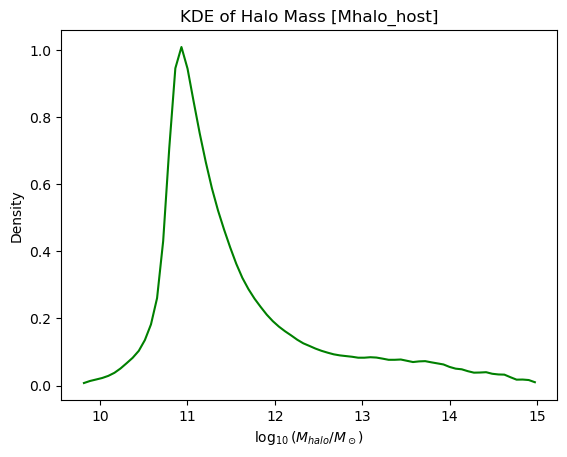

Integral of KDE: 0.9989855223345695


In [9]:
HaloM_filtered = HaloM[HaloM > 0] #There should never be values less than 0 in this dataset anyways, but still a good failsafe
HaloM_log = np.log10(HaloM_filtered) #Log values instead of axis

# scipy kde, not seaborn (yet)
kde = gaussian_kde(HaloM_log)

# Create a grid to evaluate the KDE
x_vals = np.linspace(min(HaloM_log), max(HaloM_log), 75)
kde_vals = kde(x_vals)

plt.plot(x_vals, kde_vals, color='g')
plt.xlabel(r'$\log_{10}(M_{halo}/M_\odot)$')
plt.ylabel("Density")
plt.title("KDE of Halo Mass [Mhalo_host]")
plt.show()

# Numerically integrate the KDE to check if the integral is 1
integral = np.trapz(kde_vals, x_vals)
print(f"Integral of KDE: {integral}")

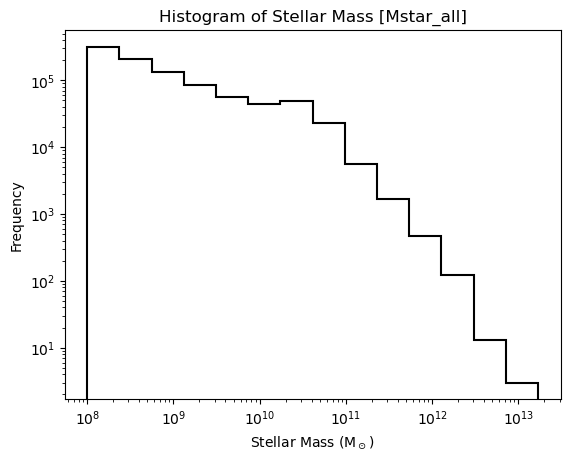

In [10]:
StellarM = shark_csv['Mstar_all']

# Define logarithmically spaced bins
bins2 = np.logspace(np.log10(StellarM.min()), np.log10(StellarM.max()), 15, base=10)

plt.hist(StellarM, bins=bins2, log=True,histtype='step',linewidth=1.5,color='black')
plt.xscale('log')
plt.xlabel(r'Stellar Mass (M$_\odot$)')
plt.ylabel('Frequency')
plt.title('Histogram of Stellar Mass [Mstar_all]')
plt.show()

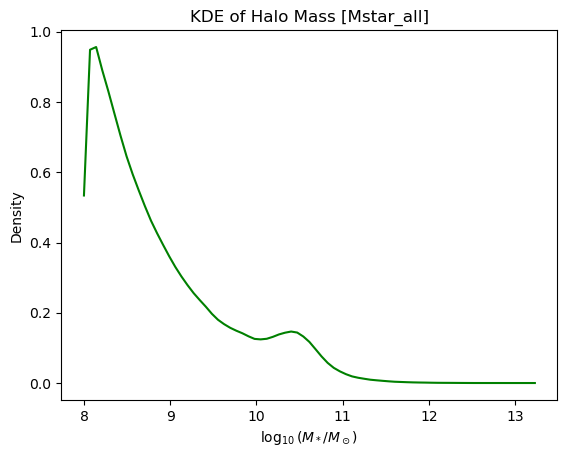

Integral of KDE: 0.9989855223345695


In [11]:
StellarM_filtered = StellarM[StellarM > 0] #There should never be values less than 0 in this dataset anyways, but still a good failsafe
StellarM_log = np.log10(StellarM_filtered) #Log values instead of axis

# scipy kde, not seaborn (yet)
kde1 = gaussian_kde(StellarM_log)

# Create a grid to evaluate the KDE
x_vals1 = np.linspace(min(StellarM_log), max(StellarM_log), 75)
kde_vals1 = kde1(x_vals1)

plt.plot(x_vals1, kde_vals1, color='g')
plt.xlabel(r'$\log_{10}(M_*/M_\odot)$')
plt.ylabel("Density")
plt.title("KDE of Halo Mass [Mstar_all]")
plt.show()

# Numerically integrate the KDE to check if the integral is 1
integral = np.trapz(kde_vals, x_vals)
print(f"Integral of KDE: {integral}")

In [12]:
#plt.scatter(shark_csv['Mhalo_host'],shark_csv['Mstar_all'],s=0.5,alpha=0.1)
#plt.xscale('log')
#plt.yscale('log')
#plt.xlabel(r'Halo Mass (M$_\odot$)')
#plt.ylabel(r'Stellar Mass (M$_\odot$)')
#plt.title('Stellar Mass vs. Halo Mass of SHARK z=0')

(100000054.8066953, 16924245858628.352)

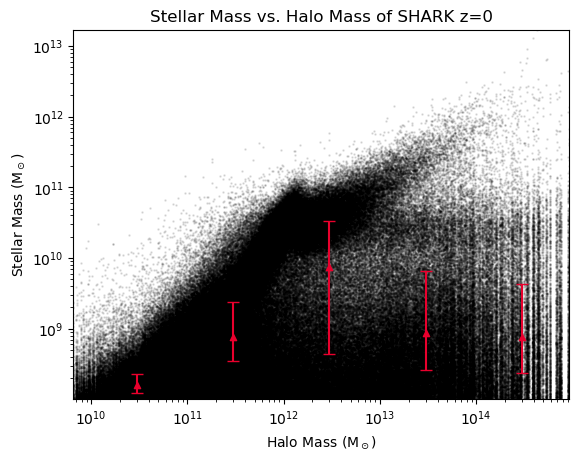

In [13]:
#Min and max log values of Mhalo_host
lowLog = math.log10(min(shark_csv['Mhalo_host']))
highLog = math.log10(max(shark_csv['Mhalo_host']))
#Round
lowLog = round(lowLog,0)
highLog = round(highLog,0)
#make log bins array
logBins = np.logspace(lowLog, highLog, num=int(highLog - lowLog) + 1)

#X values for binned data
xVals = logBins[:-1]
xVals = xVals *3

# MEDIAN
result = binned_statistic(shark_csv['Mhalo_host'], shark_csv['Mstar_all'], statistic='median',bins=logBins)
bin_medians = result.statistic

#PERCENTILES
# 25th percentile
percentile_25 = binned_statistic(shark_csv['Mhalo_host'], shark_csv['Mstar_all'], statistic=lambda values: np.percentile(values, 25), bins=logBins)
p25 = percentile_25.statistic
# 75th percentile
percentile_75 = binned_statistic(shark_csv['Mhalo_host'], shark_csv['Mstar_all'], statistic=lambda values: np.percentile(values, 75), bins=logBins)
p75 = percentile_75.statistic

#Plotting
plt.scatter(shark_csv['Mhalo_host'],shark_csv['Mstar_all'],s=0.8,alpha=0.1,color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Halo Mass (M$_\odot$)')
plt.ylabel(r'Stellar Mass (M$_\odot$)')
plt.title('Stellar Mass vs. Halo Mass of SHARK z=0')

#Bin plotting
plt.scatter(xVals, bin_medians,s=20,color='#E9002D',marker="^")
plt.errorbar(xVals, bin_medians, yerr=[bin_medians - p25, p75 - bin_medians], fmt='none', ecolor='#E9002D', capsize=4)

plt.xlim([min(shark_csv['Mhalo_host']), max(shark_csv['Mhalo_host'])])
plt.ylim([min(shark_csv['Mstar_all']), max(shark_csv['Mstar_all'])])

(100000054.8066953, 16924245858628.352)

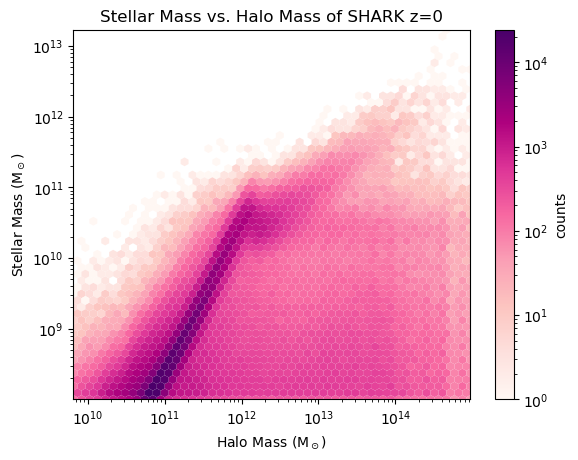

In [14]:
plt.hexbin(shark_csv['Mhalo_host'],shark_csv['Mstar_all'],gridsize=50,xscale='log',yscale='log',reduce_C_function=np.sum,mincnt=1,bins='log',linewidth=0,cmap='RdPu')
plt.xlabel(r'Halo Mass (M$_\odot$)')
plt.ylabel(r'Stellar Mass (M$_\odot$)')
plt.title('Stellar Mass vs. Halo Mass of SHARK z=0')
plt.colorbar(label='counts')

plt.xlim([min(shark_csv['Mhalo_host']), max(shark_csv['Mhalo_host'])])
plt.ylim([min(shark_csv['Mstar_all']), max(shark_csv['Mstar_all'])])

In [15]:
#redSFR = shark_csv['SFR_all']
#redSFR = np.where(redSFR < 1e-9, 1e-9, redSFR)

#plt.scatter(shark_csv['Mstar_all'], redSFR, s=0.5, alpha=0.1)
#plt.xscale('log')
#plt.yscale('log')
#plt.xlabel(r'Stellar Mass (M$_\odot$)')
#plt.ylabel(r'SFR (M$_\odot$ yr$^{-1}$)')
#plt.title('Star Forming Main Sequence of SHARK z=0')

(5e-10, 4448.072629524515)

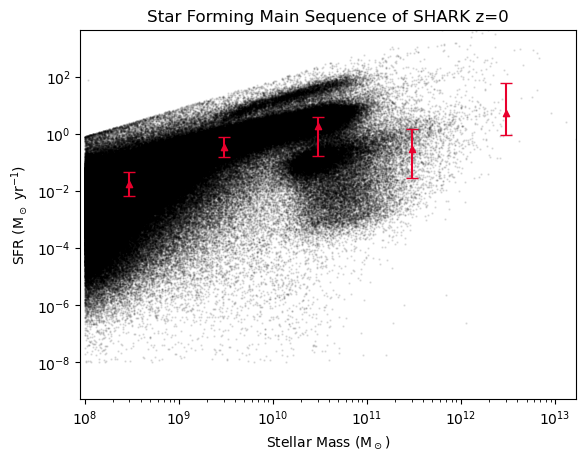

In [16]:
SFR = shark_csv['SFR_all']
Mstar_all = shark_csv['Mstar_all']

# Apply the threshold to SFR and get the corresponding mask
thresh = 1e-8 #could go down very far, like -27
mask = SFR >= thresh

SFRreg = SFR[mask]
Mstar_filtered = Mstar_all[mask]

###############################
#Min and max log values
SFRlowLog = math.log10(min(Mstar_filtered))
SFRhighLog = math.log10(max(Mstar_filtered))
#Round
SFRlowLog = round(SFRlowLog,0)
SFRhighLog = round(SFRhighLog,0)
#make log bins array
SFRlogBins = np.logspace(SFRlowLog, SFRhighLog, num=int(SFRhighLog - SFRlowLog) + 1)

#X values for binned data
xVals = SFRlogBins[:-1]
xVals = xVals *3

# MEDIAN
result = binned_statistic(Mstar_filtered, SFRreg, statistic='median',bins=SFRlogBins)
bin_medians = result.statistic

#PERCENTILES
# 25th percentile
percentile_25 = binned_statistic(Mstar_filtered, SFRreg, statistic=lambda values: np.percentile(values, 25), bins=SFRlogBins)
p25 = percentile_25.statistic
# 75th percentile
percentile_75 = binned_statistic(Mstar_filtered, SFRreg, statistic=lambda values: np.percentile(values, 75), bins=SFRlogBins)
p75 = percentile_75.statistic
###################################


plt.scatter(Mstar_filtered, SFRreg, s=0.5, alpha=0.1,color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Stellar Mass (M$_\odot$)')
plt.ylabel(r'SFR (M$_\odot$ yr$^{-1}$)')
plt.title('Star Forming Main Sequence of SHARK z=0')

#Bin plotting
plt.scatter(xVals, bin_medians,s=20,color='#E9002D',marker="^")
plt.errorbar(xVals, bin_medians, yerr=[bin_medians - p25, p75 - bin_medians], fmt='none', ecolor='#E9002D', capsize=4)

plt.xlim([min(Mstar_filtered)-10**7, max(Mstar_filtered)])
plt.ylim([5e-10, max(SFRreg)])

(5e-10, 4448.072629524515)

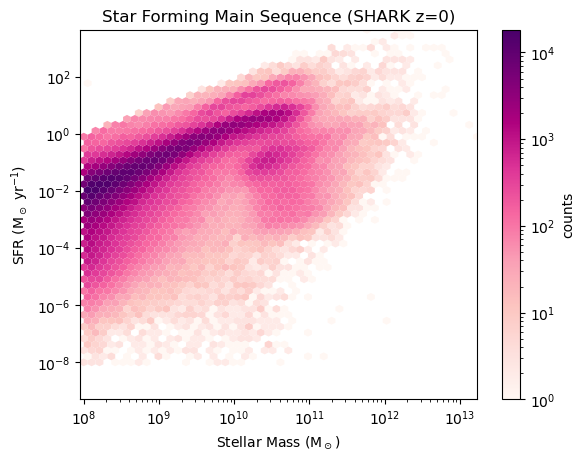

In [17]:
plt.hexbin(Mstar_filtered, SFRreg,gridsize=50,xscale='log',yscale='log',reduce_C_function=np.sum,mincnt=1,bins='log',linewidth=0,cmap='RdPu')
plt.ylabel(r'SFR (M$_\odot$ yr$^{-1}$)')
plt.xlabel(r'Stellar Mass (M$_\odot$)')
plt.title('Star Forming Main Sequence (SHARK z=0)')
plt.colorbar(label='counts')

plt.xlim([min(Mstar_filtered)-10**7, max(Mstar_filtered)])
plt.ylim([5e-10, max(SFRreg)])

Text(0.5, 1.0, 'sSFR')

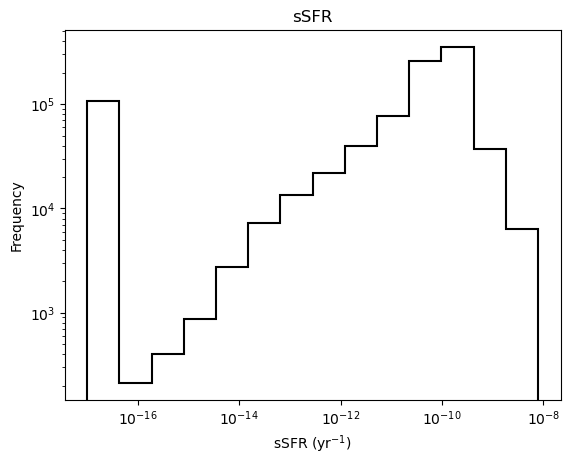

In [18]:
SSFR = shark_csv['SFR_all'] / shark_csv['Mstar_all']  
SSFR = np.where(SSFR < 1e-17, 1e-17, SSFR)
thresh = 1e-7 
SSFRreg = SSFR[SSFR <= thresh]
SSFRreg = SSFRreg[SSFRreg != 0]

# Define logarithmically spaced bins
bins3 = np.logspace(np.log10(SSFRreg.min()), np.log10(SSFRreg.max()), 15, base=10)

plt.hist(SSFRreg, bins=bins3, log=True,histtype='step',linewidth=1.5,color='black')
plt.xscale('log')
plt.xlabel('sSFR (yr$^{-1}$)')
plt.ylabel('Frequency')
plt.title('sSFR')

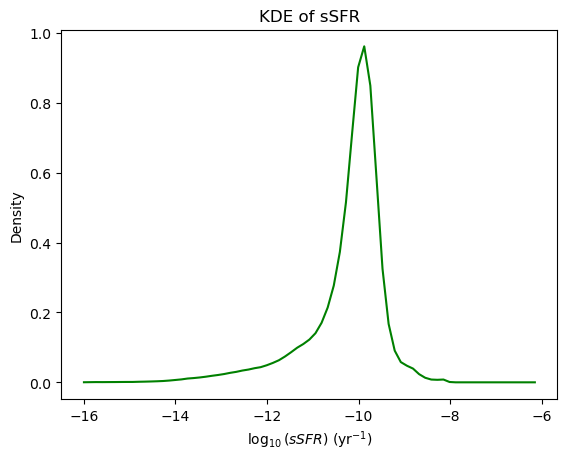

Integral of KDE: 0.9989855223345695


In [19]:
lowthresh = 1e-16
highthresh = 1e-7 

SSFRkde = SSFR[SSFR <= highthresh]
SSFRkde = SSFR[lowthresh <= SSFR] 
SSFRkde = SSFRkde[SSFRkde != 0]

SSFRkde_log = np.log10(SSFRkde) #Log values instead of axis

# scipy kde, not seaborn (yet)
kdeSSFR = gaussian_kde(SSFRkde_log)

# Create a grid to evaluate the KDE
x_valsSSFR = np.linspace(min(SSFRkde_log), max(SSFRkde_log), 75)
kde_valsSSFR = kdeSSFR(x_valsSSFR)

plt.plot(x_valsSSFR, kde_valsSSFR, color='g')
plt.xlabel(r'$\log_{10}(sSFR)$ (yr$^{-1}$)')
plt.ylabel("Density")
plt.title("KDE of sSFR")
plt.show()

# Numerically integrate the KDE to check if the integral is 1
integral = np.trapz(kde_vals, x_vals)
print(f"Integral of KDE: {integral}")

In [20]:
#contour plot

Text(0.5, 1.0, 'SHMR of SHARK z=0')

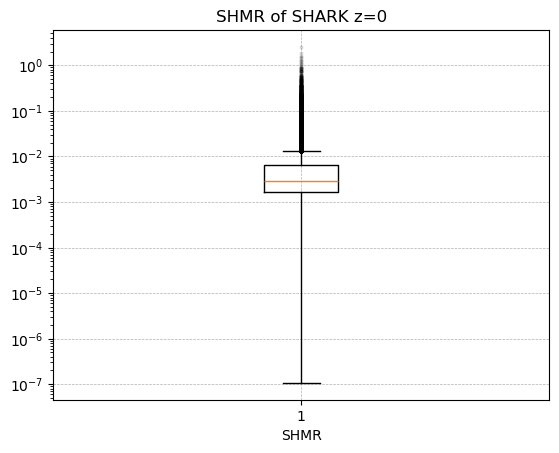

In [21]:
SHMR = StellarM / HaloM

#print(HaloM,StellarM,SHMR)
flierprops = dict(marker='o', markerfacecolor='black', markersize=2, linestyle='none', alpha=0.1)

plt.boxplot(SHMR,flierprops=flierprops)
plt.yscale('log')
plt.grid(True, which='major', linestyle='--', linewidth=0.5)

plt.xlabel('SHMR')
plt.title('SHMR of SHARK z=0')

Text(0.5, 1.0, 'SHMR of SHARK z=0')

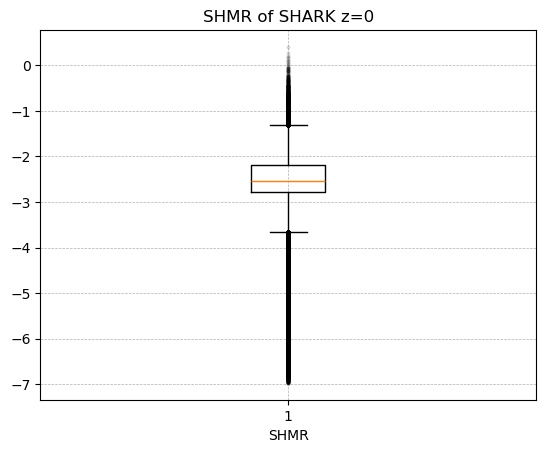

In [22]:
plt.boxplot(np.log10(SHMR),flierprops=flierprops)
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.xlabel('SHMR')
plt.title('SHMR of SHARK z=0')

Text(0.5, 1.0, 'SHMR of SHARK z=0')

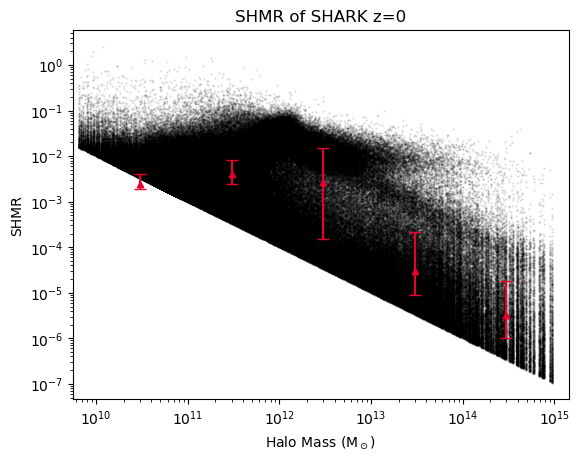

In [23]:
###############################
#Min and max log values
SFRlowLog = math.log10(min(HaloM))
SFRhighLog = math.log10(max(HaloM))
#Round
SFRlowLog = round(SFRlowLog,0)
SFRhighLog = round(SFRhighLog,0)
#make log bins array
SFRlogBins = np.logspace(SFRlowLog, SFRhighLog, num=int(SFRhighLog - SFRlowLog) + 1)

#X values for binned data
xVals = SFRlogBins[:-1]
xVals = xVals *3

# MEDIAN
result = binned_statistic(HaloM, SHMR, statistic='median',bins=SFRlogBins)
bin_medians = result.statistic

#PERCENTILES
# 25th percentile
percentile_25 = binned_statistic(HaloM, SHMR, statistic=lambda values: np.percentile(values, 25), bins=SFRlogBins)
p25 = percentile_25.statistic
# 75th percentile
percentile_75 = binned_statistic(HaloM, SHMR, statistic=lambda values: np.percentile(values, 75), bins=SFRlogBins)
p75 = percentile_75.statistic
###################################

plt.scatter(HaloM,SHMR,s=0.5, alpha=0.1,color='black')
plt.xscale('log')
plt.yscale('log')

#Bin plotting
plt.scatter(xVals, bin_medians,s=20,color='#E9002D',marker="^")
plt.errorbar(xVals, bin_medians, yerr=[bin_medians - p25, p75 - bin_medians], fmt='none', ecolor='#E9002D', capsize=4)

plt.xlim([min(HaloM)-10**9, max(HaloM)+5*10**14])

plt.xlabel(r'Halo Mass (M$_\odot$)')
plt.ylabel('SHMR')
plt.title('SHMR of SHARK z=0')

Text(0.5, 1.0, 'SHMR of SHARK z=0')

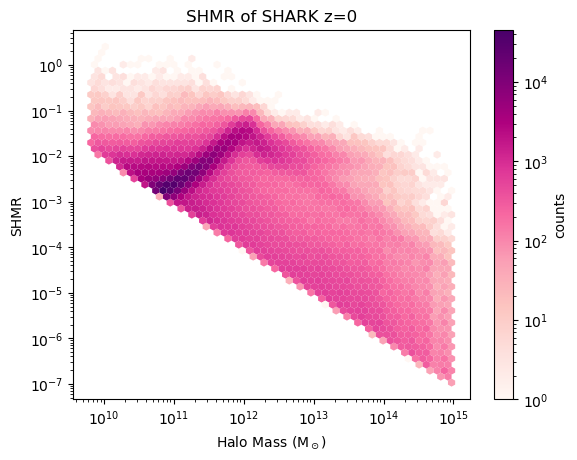

In [24]:
plt.hexbin(HaloM, SHMR,gridsize=50,xscale='log',yscale='log',reduce_C_function=np.sum,mincnt=1,bins='log',linewidth=0,cmap='RdPu')
plt.colorbar(label='counts')
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Halo Mass (M$_\odot$)')
plt.ylabel('SHMR')
plt.title('SHMR of SHARK z=0')

In [25]:
#what do they use to put multiple plots in the same image? side by side?
#Rosemary McNeiss

#Separate out centrals
#Show vs stellar mass

#plots for just centrals, explore properties

#Compare SHMR chart from other peoples plots

#Tools: webplotdigitizer 

#panels: careful with font sizes (fixed font size, scale the size of the figure around the size) usually font 2, multiple panels with same quantities, have the panels 
#share an axis without whitespace in betweeen (tight_layout option in matplotlib, does not leave too much space)